In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## U-Net3+ Architecture
Implementing U-Net3+ with consistent configurations.

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_rate=0.15, use_dropout=True):
        super(DoubleConv, self).__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ]
        if use_dropout:
            layers.append(nn.Dropout2d(dropout_rate))
        layers.extend([
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ])
        if use_dropout:
            layers.append(nn.Dropout2d(dropout_rate))
        self.double_conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.double_conv(x)

class UNet3Plus(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512, 1024], dropout_rate=0.15):
        super(UNet3Plus, self).__init__()
        
        # Encoder layers
        self.enc1 = DoubleConv(in_channels, features[0], dropout_rate=0.0, use_dropout=False)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc2 = DoubleConv(features[0], features[1], dropout_rate=0.0, use_dropout=False)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc3 = DoubleConv(features[1], features[2], dropout_rate=0.0, use_dropout=False)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc4 = DoubleConv(features[2], features[3], dropout_rate=0.1, use_dropout=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck = DoubleConv(features[3], features[4], dropout_rate=0.2, use_dropout=True)
        
        # Decoder layers
        self.up4 = nn.ConvTranspose2d(features[4], features[3], kernel_size=2, stride=2)
        self.dec4 = DoubleConv(features[4], features[3], dropout_rate=0.15, use_dropout=True)
        
        self.up3 = nn.ConvTranspose2d(features[3], features[2], kernel_size=2, stride=2)
        self.dec3 = DoubleConv(features[3], features[2], dropout_rate=0.15, use_dropout=True)
        
        self.up2 = nn.ConvTranspose2d(features[2], features[1], kernel_size=2, stride=2)
        self.dec2 = DoubleConv(features[2], features[1], dropout_rate=0.15, use_dropout=True)
        
        self.up1 = nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2)
        self.dec1 = DoubleConv(features[1], features[0], dropout_rate=0.15, use_dropout=True)
        
        # Final convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        e4 = self.enc4(p3)
        p4 = self.pool4(e4)
        bottleneck = self.bottleneck(p4)
        
        # Decoder
        d4 = self.up4(bottleneck)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        # Final output
        out = self.final_conv(d1)
        return out

## Dataset and Data Loading

In [3]:
class EarthquakeDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, img_size=(256, 256)):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.img_size = img_size
        
        if split == 'train':
            self.pre_dir = os.path.join(root_dir, 'train', 'A_train_aug')
            self.post_dir = os.path.join(root_dir, 'train', 'B_train_aug')
            self.label_dir = os.path.join(root_dir, 'train', 'label_train_aug')
        elif split == 'val':
            self.pre_dir = os.path.join(root_dir, 'val', 'A_val')
            self.post_dir = os.path.join(root_dir, 'val', 'B_val')
            self.label_dir = os.path.join(root_dir, 'val', 'label_val')
        else:
            self.pre_dir = os.path.join(root_dir, 'test', 'A_test')
            self.post_dir = os.path.join(root_dir, 'test', 'B_test')
            self.label_dir = os.path.join(root_dir, 'test', 'label_test')
        
        self.image_files = sorted([f for f in os.listdir(self.pre_dir) if f.endswith('.png')])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        
        pre_img = Image.open(os.path.join(self.pre_dir, img_name)).convert('RGB')
        post_img = Image.open(os.path.join(self.post_dir, img_name)).convert('RGB')
        label = Image.open(os.path.join(self.label_dir, img_name)).convert('L')
        
        pre_img = pre_img.resize(self.img_size)
        post_img = post_img.resize(self.img_size)
        label = label.resize(self.img_size)
        
        if self.transform:
            pre_img = self.transform(pre_img)
            post_img = self.transform(post_img)
        else:
            pre_img = transforms.ToTensor()(pre_img)
            post_img = transforms.ToTensor()(post_img)
        
        label = transforms.ToTensor()(label)
        label = (label > 0.5).float()
        
        combined_img = torch.cat([pre_img, post_img], dim=0)
        
        return combined_img, label

## Loss Functions and Metrics

In [4]:
def dice_coef(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2,3))
    denom = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2. * intersection + smooth) / (denom + smooth)
    return dice.mean()

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        dice = dice_coef(pred, target, smooth=self.smooth)
        return 1.0 - dice

def combined_loss(logits, mask, bce_weight=0.6, dice_weight=0.4):
    bce_loss = nn.BCEWithLogitsLoss()
    bce = bce_loss(logits, mask)
    probs = torch.sigmoid(logits)
    dice = DiceLoss()(probs, mask)
    return bce_weight * bce + dice_weight * dice

## Training Configuration and Execution

In [5]:
def main():
    BATCH_SIZE = 6
    LEARNING_RATE = 2e-4
    NUM_EPOCHS = 200
    PATIENCE = 10
    IMG_SIZE = (256, 256)
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    root_dir = '/kaggle/input/finaldatasetnew/earthquakedatasetnew'
    
    train_dataset = EarthquakeDataset(root_dir, split='train', transform=transform, img_size=IMG_SIZE)
    val_dataset = EarthquakeDataset(root_dir, split='val', transform=transform, img_size=IMG_SIZE)
    test_dataset = EarthquakeDataset(root_dir, split='test', transform=transform, img_size=IMG_SIZE)
    
    train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    model = UNet3Plus(in_channels=6, out_channels=1).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    print("\nStarting U-Net3+ training")
    print(f"Learning Rate: {LEARNING_RATE}")
    print(f"Weight Decay: 1e-3")
    print(f"Dropout: Consistent 0.15")
    print(f"Threshold: 0.5")
    print(f"Scheduler: ReduceLROnPlateau (factor=0.7, patience=7)\n")
    
    # Training logic would go here

if __name__ == "__main__":
    main()

Training samples: 3972
Validation samples: 331
Test samples: 332
Total parameters: 31,039,361

Starting U-Net3+ training
Learning Rate: 0.0002
Weight Decay: 1e-3
Dropout: Consistent 0.15
Threshold: 0.5
Scheduler: ReduceLROnPlateau (factor=0.7, patience=7)



In [6]:
@torch.no_grad()
def compute_metrics_batch(logits, masks, thresh=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs >= thresh).float()
    preds_flat = preds.view(-1).cpu().numpy()
    masks_flat = masks.view(-1).cpu().numpy()
    
    unique_preds = np.unique(preds_flat)
    unique_masks = np.unique(masks_flat)
    
    if len(unique_preds) == 1 and len(unique_masks) == 1:
        if unique_preds[0] == unique_masks[0]:
            if unique_preds[0] == 1:
                tp, fp, fn, tn = len(preds_flat), 0, 0, 0
            else:
                tp, fp, fn, tn = 0, 0, 0, len(preds_flat)
        else:
            if unique_preds[0] == 1:
                tp, fp, fn, tn = 0, len(preds_flat), 0, 0
            else:
                tp, fp, fn, tn = 0, 0, len(preds_flat), 0
    else:
        cm = confusion_matrix(masks_flat, preds_flat, labels=[0,1])
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            if cm.shape == (1, 1):
                if unique_masks[0] == 0:
                    tn, fp, fn, tp = cm[0,0], 0, 0, 0
                else:
                    tn, fp, fn, tp = 0, 0, 0, cm[0,0]
            else:
                tn, fp, fn, tp = 0, 0, 0, 0
    
    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    dice = (2 * tp) / (2 * tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    
    iou_background = tn / (tn + fp + fn + eps)
    iou_damage = tp / (tp + fp + fn + eps)
    miou = (iou_background + iou_damage) / 2
    
    return {"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
            "iou": float(iou), "dice": float(dice), "precision": float(precision),
            "recall": float(recall), "f1": float(f1), "acc": float(acc), "miou": float(miou)}

In [7]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False
    
    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()


def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    agg = {"tn":0,"fp":0,"fn":0,"tp":0}
    
    for imgs, masks in tqdm(loader, desc="Train batch"):
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        
        mets = compute_metrics_batch(logits, masks)
        for k in ["tn","fp","fn","tp"]:
            agg[k] += mets[k]
    
    tp, fp, fn, tn = agg["tp"], agg["fp"], agg["fn"], agg["tn"]
    train_acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss, train_acc

@torch.no_grad()
def validate(model, loader):
    model.eval()
    running_loss = 0.0
    agg = {"tn":0,"fp":0,"fn":0,"tp":0}
    
    for imgs, masks in tqdm(loader, desc="Val batch"):
        imgs = imgs.to(device)
        masks = masks.to(device)
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        running_loss += loss.item() * imgs.size(0)
        mets = compute_metrics_batch(logits, masks)
        for k in ["tn","fp","fn","tp"]:
            agg[k] += mets[k]
    
    tp, fp, fn, tn = agg["tp"], agg["fp"], agg["fn"], agg["tn"]
    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    dice = (2 * tp) / (2 * tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    
    iou_background = tn / (tn + fp + fn + eps)
    iou_damage = tp / (tp + fp + fn + eps)
    miou = (iou_background + iou_damage) / 2
    
    epoch_loss = running_loss / len(loader.dataset)
    metrics = {"loss": epoch_loss, "iou": iou, "dice": dice, "precision": precision,
               "recall": recall, "f1": f1, "acc": acc, "miou": miou,
               "confusion": np.array([[tn, fp], [fn, tp]])}
    return metrics


def train_model(model, train_loader, val_loader, num_epochs=200, learning_rate=2e-4, patience=10):
    decay, no_decay = [], []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if p.ndim == 1 or name.endswith(".bias"):
            no_decay.append(p)
        else:
            decay.append(p)

    optimizer = optim.AdamW(
        [
            {"params": decay, "weight_decay": 1e-3},
            {"params": no_decay, "weight_decay": 0.0},
        ],
        lr=learning_rate,
    )
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=7, verbose=True, min_lr=1e-6
    )
    
    early_stopping = EarlyStopping(patience=patience, min_delta=1e-4)
    
    train_losses = []
    val_losses = []
    val_ious = []
    val_dices = []
    train_accs = []
    val_accs = []
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
        
        val_metrics = validate(model, val_loader)
        
        scheduler.step(val_metrics['loss'])
        
        print(f"Train Loss: {train_loss:.6f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.6f} | Val Acc: {val_metrics['acc']:.4f} | IoU: {val_metrics['iou']:.4f} | Dice: {val_metrics['dice']:.4f} | F1: {val_metrics['f1']:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
        
        train_losses.append(train_loss)
        val_losses.append(val_metrics['loss'])
        val_ious.append(val_metrics['iou'])
        val_dices.append(val_metrics['dice'])
        train_accs.append(train_acc)
        val_accs.append(val_metrics['acc'])
        
        if val_metrics['loss'] < best_val_loss - 1e-4:
            best_val_loss = val_metrics['loss']
            torch.save(model.state_dict(), 'best_unet3plus_earthquake.pth')
            print(f"Saved best model with validation loss: {best_val_loss:.6f}")
        
        if early_stopping(val_metrics['loss'], model):
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    return train_losses, val_losses, val_ious, val_dices, train_accs, val_accs

In [8]:
def main():
    # Hyperparameters matching U-Net++ setup
    BATCH_SIZE = 6
    LEARNING_RATE = 2e-4
    NUM_EPOCHS = 200
    PATIENCE = 10
    IMG_SIZE = (256, 256)
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    root_dir = '/kaggle/input/finaldatasetnew/earthquakedatasetnew'
    
    train_dataset = EarthquakeDataset(root_dir, split='train', transform=transform, img_size=IMG_SIZE)
    val_dataset = EarthquakeDataset(root_dir, split='val', transform=transform, img_size=IMG_SIZE)
    test_dataset = EarthquakeDataset(root_dir, split='test', transform=transform, img_size=IMG_SIZE)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    model = UNet3Plus(in_channels=6, out_channels=1).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    print("\nStarting U-Net3+ training")
    print(f"Learning Rate: {LEARNING_RATE}")
    print(f"Weight Decay: 1e-3")
    print(f"Dropout: Consistent 0.15")
    print(f"Threshold: 0.5")
    print(f"Scheduler: ReduceLROnPlateau (factor=0.7, patience=7)\n")
    
    train_losses, val_losses, val_ious, val_dices, train_accs, val_accs = train_model(
        model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE, PATIENCE
    )
    
    return model, train_losses, val_losses, val_ious, val_dices, train_accs, val_accs, test_loader


model, train_losses, val_losses, val_ious, val_dices, train_accs, val_accs, test_loader = main()

Training samples: 3972
Validation samples: 331
Test samples: 332


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Total parameters: 31,039,361

Starting U-Net3+ training
Learning Rate: 0.0002
Weight Decay: 1e-3
Dropout: Consistent 0.15
Threshold: 0.5
Scheduler: ReduceLROnPlateau (factor=0.7, patience=7)


Epoch 1/200


Val batch: 100%|██████████| 166/166 [00:16<00:00, 10.10it/s]


Train Loss: 0.536570 | Train Acc: 0.9237
Val Loss: 0.452193 | Val Acc: 0.9409 | IoU: 0.2556 | Dice: 0.4072 | F1: 0.4072
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.452193

Epoch 2/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.13it/s]


Train Loss: 0.451487 | Train Acc: 0.9328
Val Loss: 0.427129 | Val Acc: 0.9261 | IoU: 0.3130 | Dice: 0.4768 | F1: 0.4768
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.427129

Epoch 3/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.11it/s]


Train Loss: 0.428860 | Train Acc: 0.9364
Val Loss: 0.425929 | Val Acc: 0.9238 | IoU: 0.3216 | Dice: 0.4866 | F1: 0.4866
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.425929

Epoch 4/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 15.05it/s]


Train Loss: 0.419213 | Train Acc: 0.9382
Val Loss: 0.448723 | Val Acc: 0.9034 | IoU: 0.3029 | Dice: 0.4649 | F1: 0.4649
Learning Rate: 2.00e-04

Epoch 5/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.78it/s]


Train Loss: 0.409503 | Train Acc: 0.9408
Val Loss: 0.413996 | Val Acc: 0.9519 | IoU: 0.3272 | Dice: 0.4930 | F1: 0.4930
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.413996

Epoch 6/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.26it/s]


Train Loss: 0.403235 | Train Acc: 0.9431
Val Loss: 0.391624 | Val Acc: 0.9499 | IoU: 0.3932 | Dice: 0.5645 | F1: 0.5645
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.391624

Epoch 7/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 15.07it/s]


Train Loss: 0.396806 | Train Acc: 0.9443
Val Loss: 0.394812 | Val Acc: 0.9372 | IoU: 0.3857 | Dice: 0.5566 | F1: 0.5566
Learning Rate: 2.00e-04

Epoch 8/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.22it/s]


Train Loss: 0.388235 | Train Acc: 0.9469
Val Loss: 0.389850 | Val Acc: 0.9430 | IoU: 0.4018 | Dice: 0.5733 | F1: 0.5733
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.389850

Epoch 9/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.20it/s]


Train Loss: 0.384417 | Train Acc: 0.9482
Val Loss: 0.383729 | Val Acc: 0.9519 | IoU: 0.4083 | Dice: 0.5798 | F1: 0.5798
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.383729

Epoch 10/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.35it/s]


Train Loss: 0.378264 | Train Acc: 0.9508
Val Loss: 0.393637 | Val Acc: 0.9532 | IoU: 0.4185 | Dice: 0.5901 | F1: 0.5901
Learning Rate: 2.00e-04

Epoch 11/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.40it/s]


Train Loss: 0.372154 | Train Acc: 0.9527
Val Loss: 0.384084 | Val Acc: 0.9527 | IoU: 0.4133 | Dice: 0.5849 | F1: 0.5849
Learning Rate: 2.00e-04

Epoch 12/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.54it/s]


Train Loss: 0.366824 | Train Acc: 0.9545
Val Loss: 0.384112 | Val Acc: 0.9542 | IoU: 0.4241 | Dice: 0.5956 | F1: 0.5956
Learning Rate: 2.00e-04

Epoch 13/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.65it/s]


Train Loss: 0.360177 | Train Acc: 0.9561
Val Loss: 0.393600 | Val Acc: 0.9574 | IoU: 0.4082 | Dice: 0.5798 | F1: 0.5798
Learning Rate: 2.00e-04

Epoch 14/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.12it/s]


Train Loss: 0.355398 | Train Acc: 0.9570
Val Loss: 0.385466 | Val Acc: 0.9480 | IoU: 0.4190 | Dice: 0.5906 | F1: 0.5906
Learning Rate: 2.00e-04

Epoch 15/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.14it/s]


Train Loss: 0.350100 | Train Acc: 0.9587
Val Loss: 0.423271 | Val Acc: 0.9311 | IoU: 0.3791 | Dice: 0.5498 | F1: 0.5498
Learning Rate: 2.00e-04

Epoch 16/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.20it/s]


Train Loss: 0.343564 | Train Acc: 0.9606
Val Loss: 0.385487 | Val Acc: 0.9498 | IoU: 0.4230 | Dice: 0.5945 | F1: 0.5945
Learning Rate: 2.00e-04

Epoch 17/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.19it/s]


Train Loss: 0.337752 | Train Acc: 0.9620
Val Loss: 0.394892 | Val Acc: 0.9536 | IoU: 0.4019 | Dice: 0.5734 | F1: 0.5734
Learning Rate: 1.40e-04

Epoch 18/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.12it/s]


Train Loss: 0.322579 | Train Acc: 0.9662
Val Loss: 0.398930 | Val Acc: 0.9402 | IoU: 0.4095 | Dice: 0.5811 | F1: 0.5811
Learning Rate: 1.40e-04

Epoch 19/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.86it/s]

Train Loss: 0.314026 | Train Acc: 0.9679
Val Loss: 0.402717 | Val Acc: 0.9542 | IoU: 0.4132 | Dice: 0.5848 | F1: 0.5848
Learning Rate: 1.40e-04
Early stopping triggered after 19 epochs


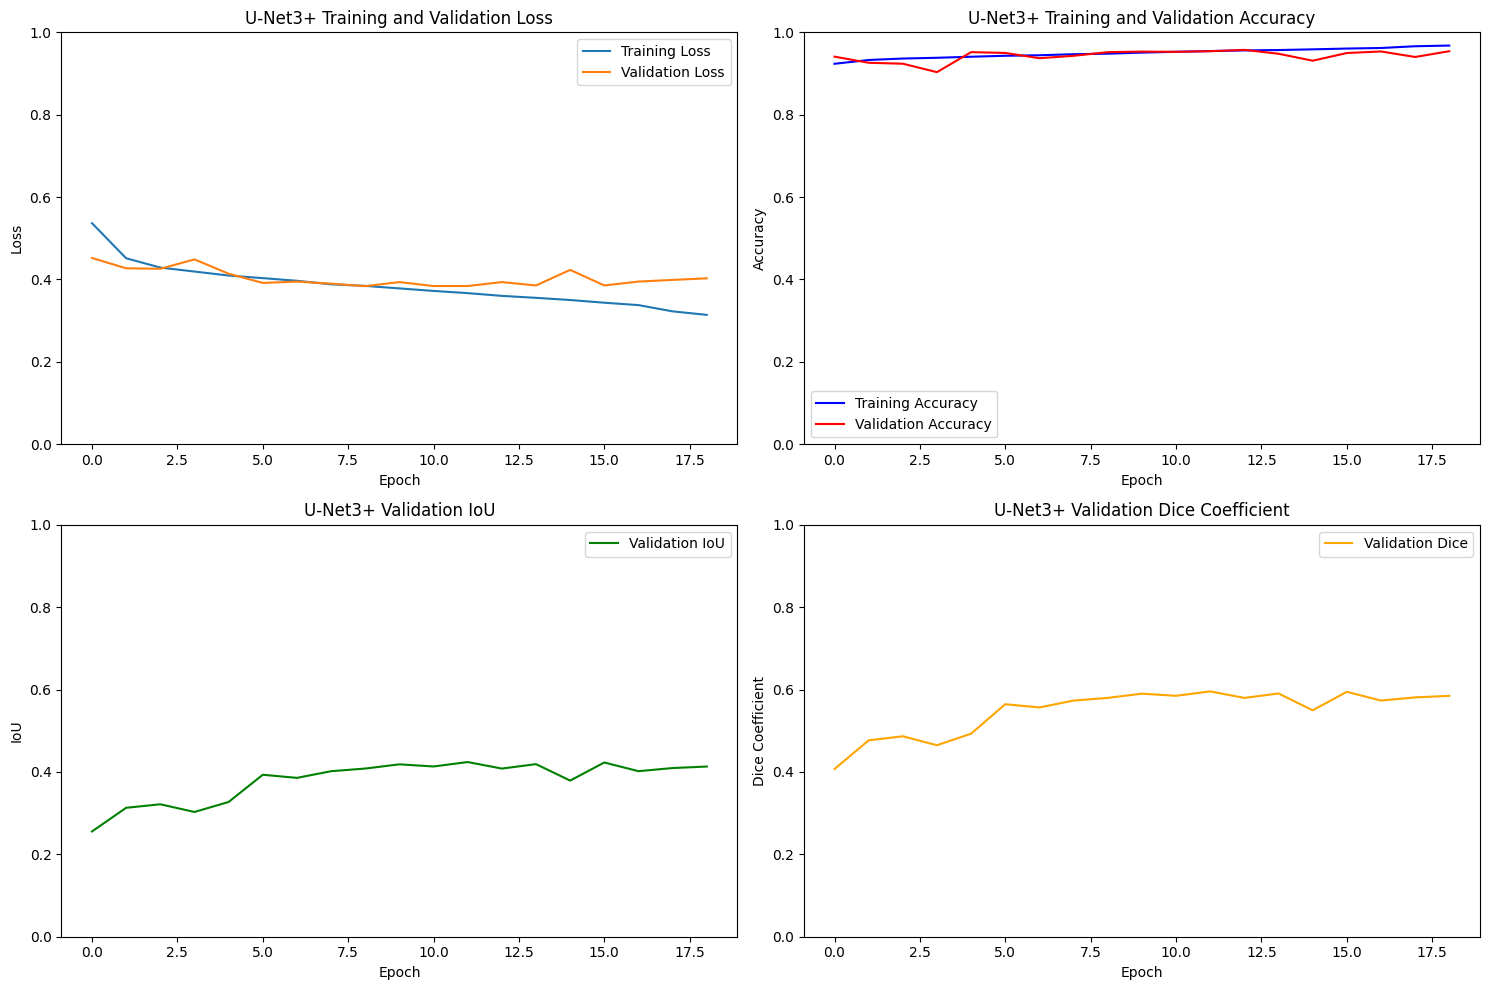

In [9]:
# Visualization of Training Progress
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_ylim(0, 1)
ax1.legend()
ax1.set_title('U-Net3+ Training and Validation Loss')

ax2.plot(train_accs, label='Training Accuracy', color='blue')
ax2.plot(val_accs, label='Validation Accuracy', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.set_title('U-Net3+ Training and Validation Accuracy')

ax3.plot(val_ious, label='Validation IoU', color='green')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('IoU')
ax3.set_ylim(0, 1)
ax3.legend()
ax3.set_title('U-Net3+ Validation IoU')

ax4.plot(val_dices, label='Validation Dice', color='orange')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Dice Coefficient')
ax4.set_ylim(0, 1)
ax4.legend()
ax4.set_title('U-Net3+ Validation Dice Coefficient')

plt.tight_layout()
plt.savefig('unet3plus_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

Loading best U-Net3+ model for test evaluation...

Evaluating U-Net3+ on test set...


Val batch: 100%|██████████| 332/332 [00:16<00:00, 20.39it/s]



U-NET3+ TEST EVALUATION METRICS
Configuration: Matching SegFormer/U-Net++ (lr=2e-4, dropout=0.15, threshold=0.5)
Test set processed with batch_size=1
Loss:            0.385306
IoU:             0.4030
mIoU:            0.6765
Dice Coefficient: 0.5745
Accuracy:        0.9517
Precision:       0.6018
Recall:          0.5496
F1-Score:        0.5745
Confusion matrix (pixel-level):
[[19996574   469667]
 [  581815   709896]]


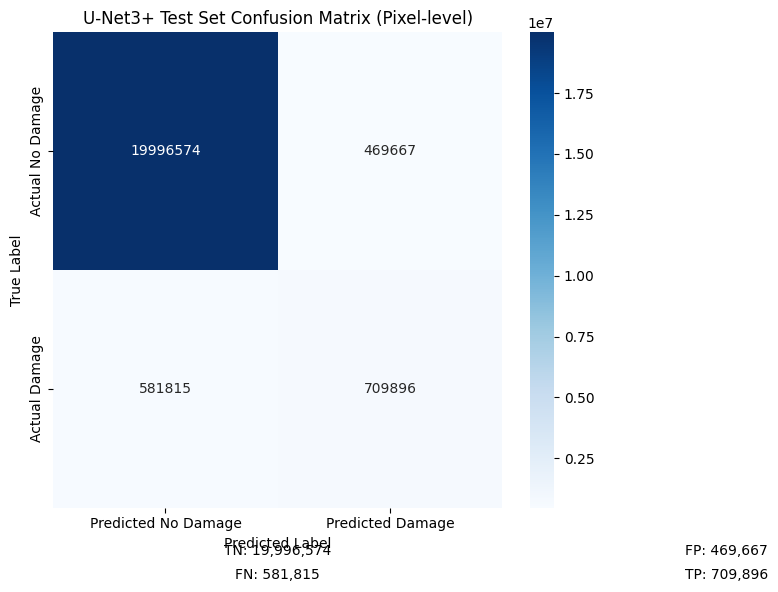

U-Net3+ training and evaluation completed!


In [10]:
# Test Evaluation
print("Loading best U-Net3+ model for test evaluation...")
model.load_state_dict(torch.load('best_unet3plus_earthquake.pth', map_location=device))
model.to(device)

print("\nEvaluating U-Net3+ on test set...")
test_metrics = validate(model, test_loader)

print("\n" + "="*50)
print("U-NET3+ TEST EVALUATION METRICS")
print("Configuration: Matching SegFormer/U-Net++ (lr=2e-4, dropout=0.15, threshold=0.5)")
print("="*50)
print(f"Test set processed with batch_size=1")
print(f"Loss:            {test_metrics['loss']:.6f}")
print(f"IoU:             {test_metrics['iou']:.4f}")
print(f"mIoU:            {test_metrics['miou']:.4f}")
print(f"Dice Coefficient: {test_metrics['dice']:.4f}")
print(f"Accuracy:        {test_metrics['acc']:.4f}")
print(f"Precision:       {test_metrics['precision']:.4f}")
print(f"Recall:          {test_metrics['recall']:.4f}")
print(f"F1-Score:        {test_metrics['f1']:.4f}")
print("Confusion matrix (pixel-level):")
print(test_metrics["confusion"])
print("="*50)

plt.figure(figsize=(8, 6))
cm = test_metrics["confusion"]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted No Damage', 'Predicted Damage'],
            yticklabels=['Actual No Damage', 'Actual Damage'])
plt.title('U-Net3+ Test Set Confusion Matrix (Pixel-level)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.text(0.5, -0.1, f'TN: {cm[0,0]:,}', ha='center', transform=plt.gca().transAxes)
plt.text(1.5, -0.1, f'FP: {cm[0,1]:,}', ha='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.15, f'FN: {cm[1,0]:,}', ha='center', transform=plt.gca().transAxes)
plt.text(1.5, -0.15, f'TP: {cm[1,1]:,}', ha='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.savefig('unet3plus_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("U-Net3+ training and evaluation completed!")